In [1]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.utils import db_to_float 

In [2]:
default_rate = 44100
default_freq = 400  # Hz
default_length = 2  # sec
default_amp = 0.999

In [3]:
def numpy_to_audio_segment(audio_arr, amp=1.0, rate=default_rate, channels=1, sample_width=4):
    audio_arr = audio_arr / (abs(audio_arr).max())
    audio_arr_trans = ((2**(8*sample_width-1)-1) * amp * audio_arr).astype(np.int32)
    audio_segment = AudioSegment(audio_arr_trans.tobytes(),
                                 frame_rate=rate,
                                 sample_width=sample_width,
                                 channels=channels)
    return audio_segment

def audio_segment_to_numpy(seg, th=1.0):
    frame_rate = seg.frame_rate
    seg_arr = np.array(seg.get_array_of_samples())
    seg_arr = th * seg_arr / seg.max_possible_amplitude
    return seg_arr, frame_rate

In [4]:
def generate_sound(freq=default_freq, rate=default_rate, length=default_length, amp=default_amp, db=None):
    if db:
        amp = db_to_float(db)
    sound_arr = np.sin(2 * np.pi * np.arange(rate*length) * freq/rate)
    return numpy_to_audio_segment(sound_arr, amp=amp, rate=rate)

# mel scale

In [5]:
amp = 0.25

In [6]:
freq = 500
generate_sound(freq=freq, amp=amp)

In [7]:
freq = 550
generate_sound(freq=freq, amp=amp)

In [8]:
freq = 1000
generate_sound(freq=freq, amp=amp)

In [9]:
freq = 1050
generate_sound(freq=freq, amp=amp)

In [10]:
freq = 2000
generate_sound(freq=freq, amp=amp)

In [11]:
freq = 2050
generate_sound(freq=freq, amp=amp)

# spectrogram

In [12]:
import librosa
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np

data from musicnet 
- https://homes.cs.washington.edu/~thickstn/musicnet.html

In [16]:
wav_path_piano = './data/1752.wav'
# wav_path_string = '/media/data_disk3/data_music/musicnet/train_data/1805.wav'

In [17]:
arr_piano, sr_piano = librosa.load(wav_path_piano, sr=None)
# arr_string, sr_string = librosa.load(wav_path_string, sr=None)

In [18]:
# sr_piano, sr_string

In [19]:
window_n = int(0.3 * sr_piano)

In [82]:
f_piano, t_piano, freq_amp_piano = stft(arr_piano, nperseg=window_n, fs=sr_piano)
# f_string, t_string, freq_amp_string = stft(arr_string, nperseg=window_n, fs=sr_piano)

In [45]:
mfcc_piano = librosa.feature.mfcc(arr_piano, sr=sr_piano, n_fft=window_n, hop_length=window_n//2)

In [21]:
spec_piano = abs(freq_amp_piano)
# spec_string = abs(freq_amp_string)

In [22]:
sec = 15.2
t_index = (t_piano < sec).sum()

by frequency

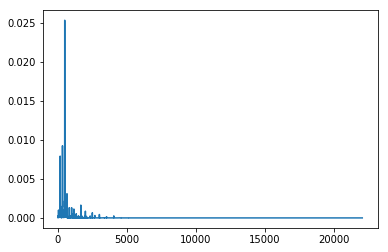

In [23]:
plt.plot(f_piano, spec_piano[:,t_index])
plt.savefig('hz.png')

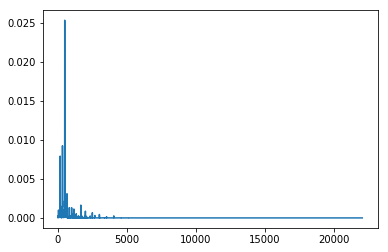

In [24]:
plt.plot(f_piano[:window_n//2], spec_piano[:window_n//2,t_index])

logarithm

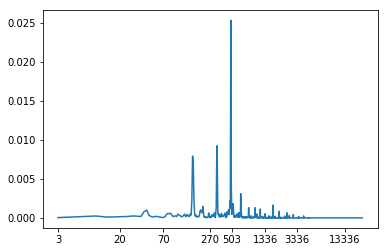

In [25]:
fig, ax = plt.subplots()
x = np.log(f_piano[1:])
y = spec_piano[1:, t_index]
bins = [0, 5, 20, 80, 150, 400, 1000, 4000]
ax.set_xticks(x[bins])
ax.set_xticklabels([int(f) for f in f_piano[1:][bins]])
ax.plot(x, y)
plt.savefig('hz_log.png')

log and db scale

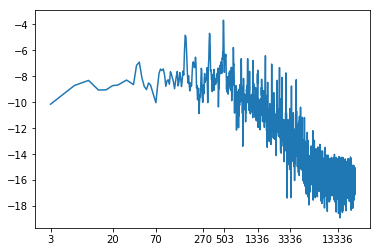

In [26]:
fig, ax = plt.subplots()
x = np.log(f_piano[1:])
y = np.log(spec_piano[1:, t_index])
bins = [0, 5, 20, 80, 150, 400, 1000, 4000]
ax.set_xticks(x[bins])
ax.set_xticklabels([int(f) for f in f_piano[1:][bins]])
ax.plot(x, y)
plt.savefig('hz_dlog.png')

mel filter bank

In [56]:
mel_mat = librosa.filters.mel(sr=sr_piano, n_fft=window_n)
f_mel = f_piano[mel_mat.argmax(axis=1)]

mel_spec_piano = np.dot(mel_mat, spec_piano)
mel_spec_piano_sq = np.dot(mel_mat, spec_piano**2)

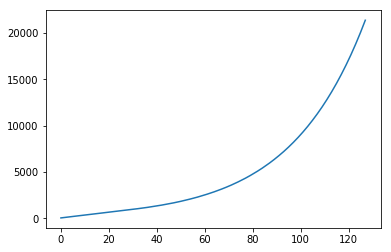

In [57]:
plt.plot(f_mel)

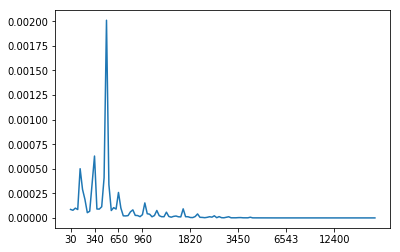

In [63]:
fig, ax = plt.subplots()
y = mel_spec_piano[:,t_index]
# y_ = mel_spec_piano_sq[:,t_index]
x = np.arange(y.shape[0])
bins = [0, 10, 20, 30, 50, 70, 90, 110]
ax.set_xticks(x[bins])
ax.set_xticklabels([int(f) for f in f_mel[bins]])
ax.plot(y)
# ax.plot(y_)
plt.savefig('mel_bank.png')

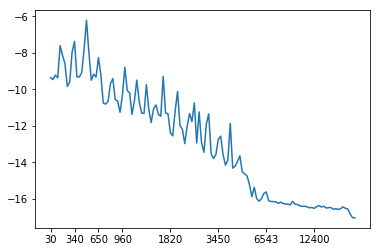

In [83]:
fig, ax = plt.subplots()
y = mel_spec_piano[:,t_index]
# y_ = mel_spec_piano_sq[:,t_index]
x = np.arange(y.shape[0])
bins = [0, 10, 20, 30, 50, 70, 90, 110]
ax.set_xticks(x[bins])
ax.set_xticklabels([int(f) for f in f_mel[bins]])
ax.plot(np.log(y))
# ax.plot(np.log(y_))
plt.savefig('mel_bank_log.png')

mfcc

In [97]:
from scipy.fftpack import dct, idct

In [115]:
dct_mel = dct(np.log(y), norm='ortho')

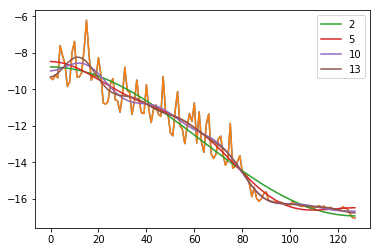

In [131]:
n_lst = [2,5,10,13]
plt.plot(np.log(y))
plt.plot(idct(dct_mel, norm='ortho'))
for n in n_lst:
    mel_n = np.zeros_like(dct_mel)
    mel_n[:n] = dct_mel[:n]
    plt.plot(idct(mel_n, norm='ortho'), label=n)
plt.legend()

note: it seems there are some ambiguity in definition of mfcc, here we just show the phylosophy of mfcc

In [125]:
def freq_to_mel(freq):
    return 1000/np.log(2) * np.log(1+freq/1000)

Text(0.5,0,'hz')

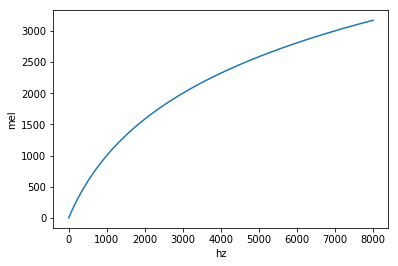

In [126]:
plt.plot(freq_to_mel(np.arange(8000)))
plt.ylabel('mel')
plt.xlabel('hz')